In [13]:
#Imports
#Dataprep
import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiMapsMasker
from sklearn.decomposition import FastICA
import pandas as pd
import tarfile
import gzip
#sim required
import random
import pingouin as pg
import seaborn as sns
#GNN required
import torch
import torch.nn.functional as F
from torch.nn import Linear
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score

In [14]:
def mult_chance(row,mult_lst,chance):
    if np.random.random() < chance:
        return row * mult_lst
    return row

def gen_data(mult_lst,num_rows,num_features = 10):
    # gen dataframe of random values from 0.1 to 0.2
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, num_features)))

    # multiply some rows by a specific list at a certain chance
    df = df.apply(lambda x: mult_chance(x,mult_lst,0.2), axis=1)
    return df

kwarg_dict = {'vmin':-1, 'vmax':1,'center':0}
fisher_dict = {'vmin':-3, 'vmax':3,'center':0}

def plot_corr_pcorr(data):
    fig, ax = plt.subplots(2,2,figsize=(11,9))
    
    corr = data.corr()
    pcorr = data.pcorr()
    fcorr = apply_fisher(corr)
    fpcorr = apply_fisher(pcorr)
    
    sns.heatmap(corr, ax=ax[0][0],**kwarg_dict)
    ax[0][0].set_title("Pearson Correlation")
    sns.heatmap(pcorr, ax=ax[0][1],**kwarg_dict)
    ax[0][1].set_title("Partial Correlation")
    
    sns.heatmap(fcorr, ax=ax[1][0],**fisher_dict)
    ax[1][0].set_title("Pearson Correlation w/ Fisher Transform")
    sns.heatmap(fpcorr, ax=ax[1][1],**fisher_dict)
    ax[1][1].set_title("Partial Correlation w/ Fisher Transform")
    
    plt.show()
    print("Pearson Positive Definite: ", positive_definite(corr))
    print("Partial Positive Definite: ", positive_definite(pcorr))
    print("Pearson w/ Fisher Transform Positive Definite: ", positive_definite(fcorr))
    print("Partial w/ Fisher Transform Positive Definite: ", positive_definite(fpcorr))

def positive_definite(data):
    # positive definite when all eigenvalues are greater than 0
    return np.all(np.linalg.eigvals(data) > 0)

def apply_fisher(data):
    numpied = data.to_numpy().copy()
    np.fill_diagonal(numpied, 0)
    return np.arctanh(numpied)

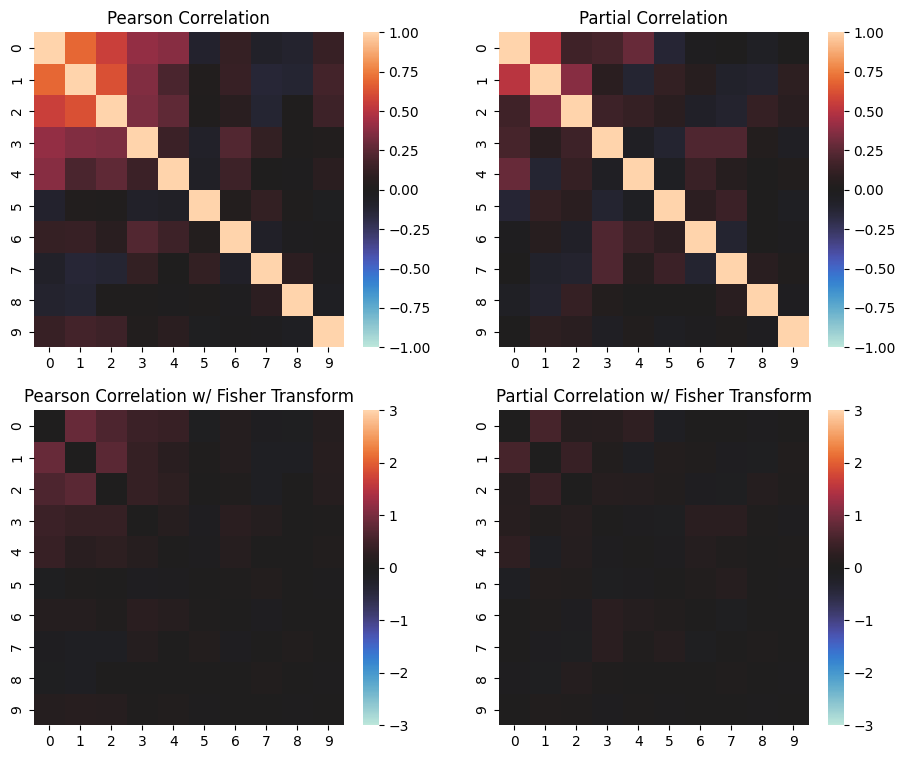

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [15]:
male_lst = [
        2,
        1.8,
        1.6,
        1.4,
        1.2,
        1,
        1,
        1,
        1,
        1
    ]

df = gen_data(male_lst,100)
plot_corr_pcorr(df)

In [30]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.119244,0.147676,0.121345,0.186005,0.187313,0.152133,0.148671,0.113603,0.111818,0.192148
1,0.124811,0.127638,0.198490,0.118497,0.171797,0.128387,0.119228,0.190402,0.129528,0.140226
2,0.163065,0.172433,0.168129,0.172390,0.197946,0.183899,0.135398,0.125773,0.164580,0.112135
3,0.168376,0.144904,0.121758,0.167538,0.196833,0.219611,0.211972,0.310459,0.220160,0.263338
4,0.199277,0.159789,0.109330,0.118244,0.140241,0.146205,0.195302,0.131508,0.185212,0.160034
...,...,...,...,...,...,...,...,...,...,...
95,0.142010,0.144797,0.115613,0.177836,0.170842,0.152680,0.263128,0.233643,0.251819,0.398454
96,0.135044,0.156255,0.162728,0.177241,0.188024,0.118638,0.116415,0.172592,0.196412,0.133121
97,0.102651,0.197759,0.184608,0.190960,0.166812,0.196105,0.245244,0.284500,0.334874,0.366361
98,0.117089,0.161663,0.162500,0.151448,0.169336,0.184321,0.147003,0.261248,0.186671,0.330908


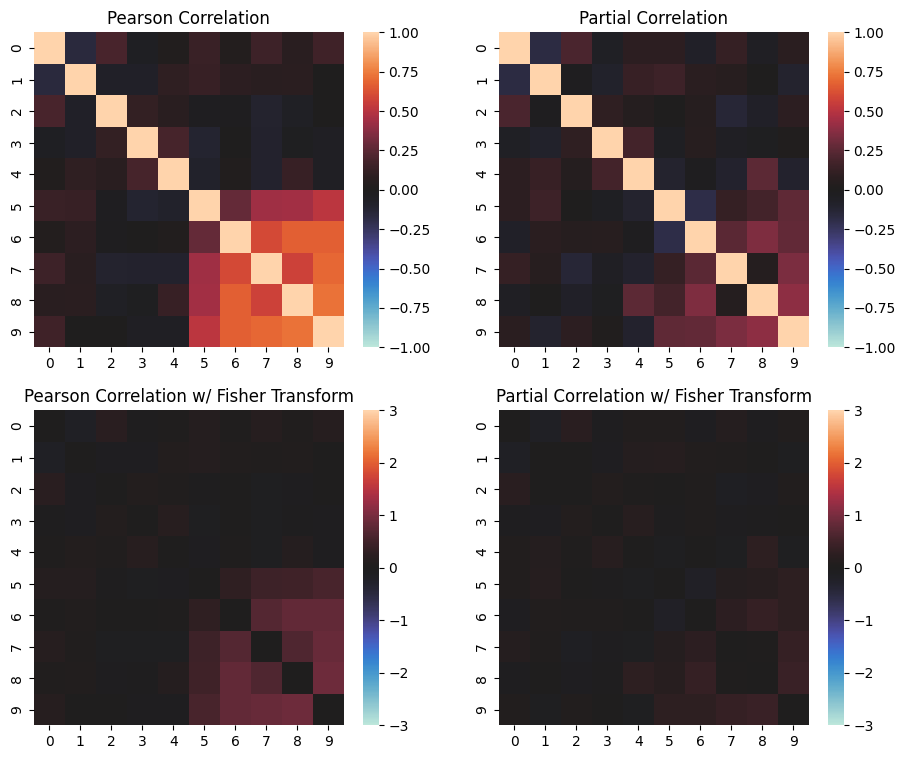

Pearson Positive Definite:  True
Partial Positive Definite:  True
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [16]:
female_lst = [
        1,
        1,
        1,
        1,
        1,
        1.2,
        1.4,
        1.6,
        1.8,
        2
    ]

df = gen_data(female_lst,100)
plot_corr_pcorr(df)

In [17]:
def gen_data2(lst1,num_rows):
    df = pd.DataFrame(np.random.uniform(0.1,0.2,size=(num_rows, 10)))
    
    for lst2 in lst1:
        df = df.apply(lambda x: mult_chance(x,lst2,0.2), axis=1)    
    return df

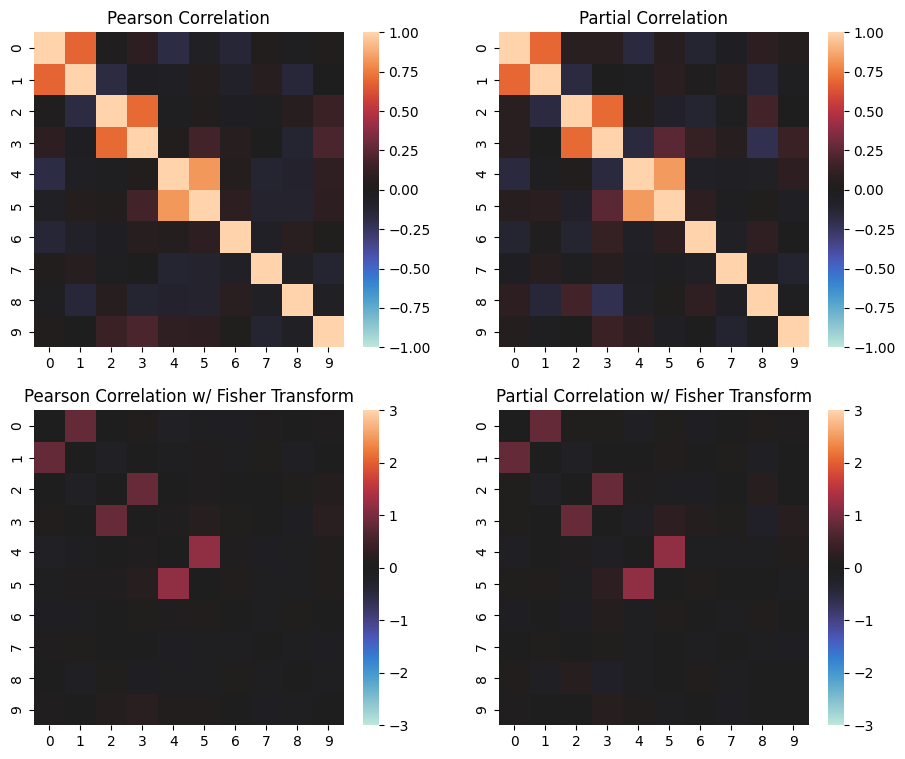

Pearson Positive Definite:  True
Partial Positive Definite:  False
Pearson w/ Fisher Transform Positive Definite:  False
Partial w/ Fisher Transform Positive Definite:  False


In [18]:
tuple_lst = [
    [2,2,1,1,1,1,1,1,1,1], # region 0 with region 1
    [1,1,2,2,1,1,1,1,1,1], # region 2 with region 3
    [1,1,1,1,2,2,1,1,1,1] # region 4 with region 5
]

df = gen_data2(tuple_lst,100)
plot_corr_pcorr(df)

In [31]:
simulated_subjects = []

while len(simulated_subjects) < 50:
    df = gen_data(male_lst,100)
    c = df.corr()
    p = df.pcorr()
    fc = apply_fisher(c)
    fpc = apply_fisher(p)
    if (not positive_definite(c)) or (not positive_definite(p)):
        continue
    simulated_subjects += [('M',p)]
while len(simulated_subjects) < 100:
    df = gen_data(female_lst,100)
    c = df.corr()
    p = df.pcorr()
    fc = apply_fisher(c)
    fpc = apply_fisher(p)
    if (not positive_definite(c)) or (not positive_definite(p)):
        continue
    simulated_subjects += [('F',p)]
random.shuffle(simulated_subjects)

In [32]:
simulated_subjects[1]

('F',
           0         1         2         3         4         5         6   
 0  1.000000 -0.168769 -0.281085 -0.146954  0.235744 -0.201380 -0.027979  \
 1 -0.168769  1.000000 -0.094341  0.029398  0.116210 -0.004272  0.004274   
 2 -0.281085 -0.094341  1.000000 -0.053234  0.265929 -0.068341 -0.088435   
 3 -0.146954  0.029398 -0.053234  1.000000  0.146845 -0.168003  0.107616   
 4  0.235744  0.116210  0.265929  0.146845  1.000000  0.010147  0.152174   
 5 -0.201380 -0.004272 -0.068341 -0.168003  0.010147  1.000000 -0.015455   
 6 -0.027979  0.004274 -0.088435  0.107616  0.152174 -0.015455  1.000000   
 7  0.031425  0.032542  0.108056  0.057157 -0.084636  0.219754  0.206264   
 8  0.153142 -0.071180  0.023392 -0.018622 -0.067840  0.096708  0.103299   
 9  0.050803 -0.039581  0.077164  0.156734  0.073690  0.179331  0.219592   
 
           7         8         9  
 0  0.031425  0.153142  0.050803  
 1  0.032542 -0.071180 -0.039581  
 2  0.108056  0.023392  0.077164  
 3  0.057157 -0.

In [33]:
sims = pd.DataFrame(simulated_subjects)

In [34]:
sims

,0,1
0,F,0 1 2 3 ...
1,F,0 1 2 3 ...
2,M,0 1 2 3 ...
3,M,0 1 2 3 ...
4,M,0 1 2 3 ...
...,...,...
95,F,0 1 2 3 ...
96,M,0 1 2 3 ...
97,M,0 1 2 3 ...
98,M,0 1 2 3 ...
